# **Project 9: Heating and cooling power DFAB**

Course: EDE WS 2025-2026 Semester Project

Date: 15.01.2025

Team Members: Aya Abd Alahi, John Riecken

## **1. Introduction**

Briefly describe the dataset and the problem you are solving. What is the target variable? Why is this prediction useful?

Predict: heating_cooling_power without using the valve settings

In [5]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# Für statistische Analysen
import statsmodels.formula.api as smf

# Für Machine Learning (Scikit-Learn) - Das brauchen wir für Part 2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression  # Das erste Modell
from sklearn.metrics import mean_squared_error, r2_score # Zum Bewerten
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


In [6]:
# import data

df = pd.read_csv('../data/dfab_2019_2022_resampled.csv')
df.head()

,Unnamed: 0,time,heating_cooling_power,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,...,y2_574,y3_371,y3_472,y3_476,y3_571,y3_574,y4_371,y5_371,y6_371,y7_371
0,0,2019-07-01 00:00:00,-3.330995,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,1.0,1.0,1.0,1.0,1.0,0.400000,1.0,1.0,1.0,1.0
1,1,2019-07-01 00:15:00,-3.087947,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0
2,2,2019-07-01 00:30:00,-3.441945,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,1.0,1.0,1.0,1.0,1.0,0.600000,1.0,1.0,1.0,1.0
3,3,2019-07-01 00:45:00,-3.274495,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0
4,4,2019-07-01 01:00:00,-3.298245,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,1.0,1.0,1.0,1.0,1.0,0.666667,1.0,1.0,1.0,1.0


In [7]:
# check metadata
# AI used for encoding

meta_df = pd.read_csv('../data/dfab_metadata.csv', encoding='iso-8859-1')
# Groups by Type and take the first row of data
meta_df.groupby('Type').first()

,NumericID,DescriptiveID,Description,Unit
Type,,,,
Electricity Kitchen,42190064,kitchen_active_power,Kitchen electric active power [kW],dfab
Electricity Total,42190139,total_active_power,Total electric active power [kW],dfab
Heating Cooling,421100172,heating_cooling_power,Heating and cooling power unit [kW],dfab
Index,Index,Index,Index,Index
Setpoint,421110050,setp_371,Temperature setpoint room 272 [°C],dfab
Solar Radiation,3200008,irrad,Global solar irradiation [W/m^2],roof
Temperature Ambient,3200000,temp_amb,Ambient temperature [°C],roof
Temperature Indoor,421110048,temp_371,Temperature room 371 [°C],dfab
Valve,421110008,y1_371,Valve 1 position room 371 [0/1],dfab


The dataset describes measurements taken at distinct regular points in time within a building (NEST). 

The measurements describe:
* the heating and cooling unit power, 
* active electric power (total and from the kitchen),
* solar radiation and ambient temperature on the roof,
* water consumption in showers for two rooms,
* the set temperature and associated actual temperature across 7 rooms (one of which has also shower -Room 571),
* various valve positions for each of the rooms 

In [8]:
# drop excluded variables
to_drop = 'y1_371 y1_472 y1_474 y1_476 y1_571 y1_573 y1_574 y2_371 y2_472 y2_476 y2_571 y2_574 y3_371 y3_472 y3_476 y3_571 y3_574 y4_371 y5_371 y6_371 y7_371'.split()
df.drop(columns=to_drop, inplace=True)
df.head()

,Unnamed: 0,time,heating_cooling_power,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,...,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
0,0,2019-07-01 00:00:00,-3.330995,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,0.0,27.500000,26.5,28.0,29.0,31.0,30.500000,31.5,25.926667,0.575526
1,1,2019-07-01 00:15:00,-3.087947,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,0.0,27.500000,26.5,28.0,29.0,30.8,30.500000,31.5,25.586667,0.689346
2,2,2019-07-01 00:30:00,-3.441945,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,0.0,27.500000,26.5,28.0,29.0,30.5,30.500000,31.5,25.373333,0.675612
3,3,2019-07-01 00:45:00,-3.274495,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,0.0,27.500000,26.5,28.0,29.0,30.5,30.466667,31.5,25.333333,0.566832
4,4,2019-07-01 01:00:00,-3.298245,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,0.0,27.333333,26.5,28.0,29.0,30.5,30.000000,31.2,24.900000,0.481446


In [9]:
df.shape

(140256, 23)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140256 entries, 0 to 140255
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             140256 non-null  int64  
 1   time                   140256 non-null  object 
 2   heating_cooling_power  138446 non-null  float64
 3   irrad                  137900 non-null  float64
 4   kitchen_active_power   138625 non-null  float64
 5   setp_371               132951 non-null  float64
 6   setp_472               133554 non-null  float64
 7   setp_474               132949 non-null  float64
 8   setp_476               132360 non-null  float64
 9   setp_571               132951 non-null  float64
 10  setp_573               132675 non-null  float64
 11  setp_574               132663 non-null  float64
 12  shower_471             138776 non-null  float64
 13  shower_571             137960 non-null  float64
 14  temp_371               137795 non-nu

### **Initial Look at the Dataset**

- all columns (except time) are floats, making preprocessing easier
- all columns have contain nulls as the non-null counts are all less than those in 'time'
  - in the source material values outside of a defined range for each measurement were set to *Missing Value* 
  - there were also network outages and temporarily defected sensors which caused NaNs
- Time is an object and not recognised by pandas as a time
- extra column (unnamed) for the index is not needed

## **2. Part 1: Exploratory Data Analysis (EDA)**

### **2.1 Statistical Summary**

Show basic stats (mean, median, std dev) and handle any missing values.


In [11]:
focus_cols = ['heating_cooling_power', 'irrad', 'total_active_power', 'kitchen_active_power',
    'temp_amb', 'shower_471', 'setp_371', 'temp_371']

df[focus_cols].describe()

,heating_cooling_power,irrad,total_active_power,kitchen_active_power,temp_amb,shower_471,setp_371,temp_371
count,138446.000000,137900.000000,138936.000000,138625.000000,139273.000000,138776.000000,132951.000000,137795.000000
mean,0.157416,184.621133,-0.105771,0.041175,12.073460,0.005121,22.138905,23.571796
std,1.833801,303.647495,1.437322,0.211394,8.459903,0.163586,2.403091,2.109775
min,-8.420386,0.000000,-6.151530,0.000000,-9.940000,0.000000,10.000000,18.500000
25%,-1.113597,0.000000,-0.376740,0.000000,5.306667,0.000000,22.000000,22.000000
50%,0.000000,11.266667,0.443226,0.000000,11.566667,0.000000,22.000000,23.000000
75%,1.496797,249.133333,0.644574,0.000000,18.033333,0.000000,23.500000,25.000000
max,6.418994,1250.000000,7.180404,5.157067,40.120000,28.270000,28.000000,46.000000


In [12]:
# chceck for missing values
df.isna().sum()

Unnamed: 0                  0
time                        0
heating_cooling_power    1810
irrad                    2356
kitchen_active_power     1631
setp_371                 7305
setp_472                 6702
setp_474                 7307
setp_476                 7896
setp_571                 7305
setp_573                 7581
setp_574                 7593
shower_471               1480
shower_571               2296
temp_371                 2461
temp_472                 2546
temp_474                 2806
temp_476                 3370
temp_571                 3018
temp_573                 2835
temp_574                 2895
temp_amb                  983
total_active_power       1320
dtype: int64

In [13]:
# columns ok to have zeros: heating_coolling, irrad, active elec, shower
# check columns: amb_temp, indoor temp, set temp

# df[df['temp_amb'] == 0]b
df[df['temp_amb'].isna()]

,Unnamed: 0,time,heating_cooling_power,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,...,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
5286,5286,2019-08-25 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5287,5287,2019-08-25 01:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5288,5288,2019-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5289,5289,2019-08-25 02:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5290,5290,2019-08-25 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105211,35035,2022-06-30 22:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105212,35036,2022-06-30 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105213,35037,2022-06-30 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105214,35038,2022-06-30 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# with ~140k rows try dropping all NaNs and removing Unnamed
df_clean = df.dropna()
df_clean = df_clean.drop(columns='Unnamed: 0')
df_clean.shape

(130303, 22)

In [15]:
df_clean.isna().sum()

time                     0
heating_cooling_power    0
irrad                    0
kitchen_active_power     0
setp_371                 0
setp_472                 0
setp_474                 0
setp_476                 0
setp_571                 0
setp_573                 0
setp_574                 0
shower_471               0
shower_571               0
temp_371                 0
temp_472                 0
temp_474                 0
temp_476                 0
temp_571                 0
temp_573                 0
temp_574                 0
temp_amb                 0
total_active_power       0
dtype: int64

In [16]:
# chekc duplicates
# df['time'].duplicated().sum()
df_clean.duplicated().sum()

np.int64(0)

In [17]:
# convert Time to timeseries dtype
df_clean['time'] = pd.to_datetime(df['time'])
df_clean = df_clean.set_index('time')
df_clean = df_clean.sort_values('time')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130303 entries, 2019-07-01 00:00:00 to 2023-06-29 23:45:00
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   heating_cooling_power  130303 non-null  float64
 1   irrad                  130303 non-null  float64
 2   kitchen_active_power   130303 non-null  float64
 3   setp_371               130303 non-null  float64
 4   setp_472               130303 non-null  float64
 5   setp_474               130303 non-null  float64
 6   setp_476               130303 non-null  float64
 7   setp_571               130303 non-null  float64
 8   setp_573               130303 non-null  float64
 9   setp_574               130303 non-null  float64
 10  shower_471             130303 non-null  float64
 11  shower_571             130303 non-null  float64
 12  temp_371               130303 non-null  float64
 13  temp_472               130303 non-null  float64
 14  te

In [18]:
df_clean.head()

,heating_cooling_power,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,setp_573,setp_574,...,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
time,,,,,,,,,,,,,,,,,,,,,
2019-07-01 00:00:00,-3.330995,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,...,0.0,27.500000,26.5,28.0,29.0,31.0,30.500000,31.5,25.926667,0.575526
2019-07-01 00:15:00,-3.087947,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,...,0.0,27.500000,26.5,28.0,29.0,30.8,30.500000,31.5,25.586667,0.689346
2019-07-01 00:30:00,-3.441945,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,...,0.0,27.500000,26.5,28.0,29.0,30.5,30.500000,31.5,25.373333,0.675612
2019-07-01 00:45:00,-3.274495,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,...,0.0,27.500000,26.5,28.0,29.0,30.5,30.466667,31.5,25.333333,0.566832
2019-07-01 01:00:00,-3.298245,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,...,0.0,27.333333,26.5,28.0,29.0,30.5,30.000000,31.2,24.900000,0.481446


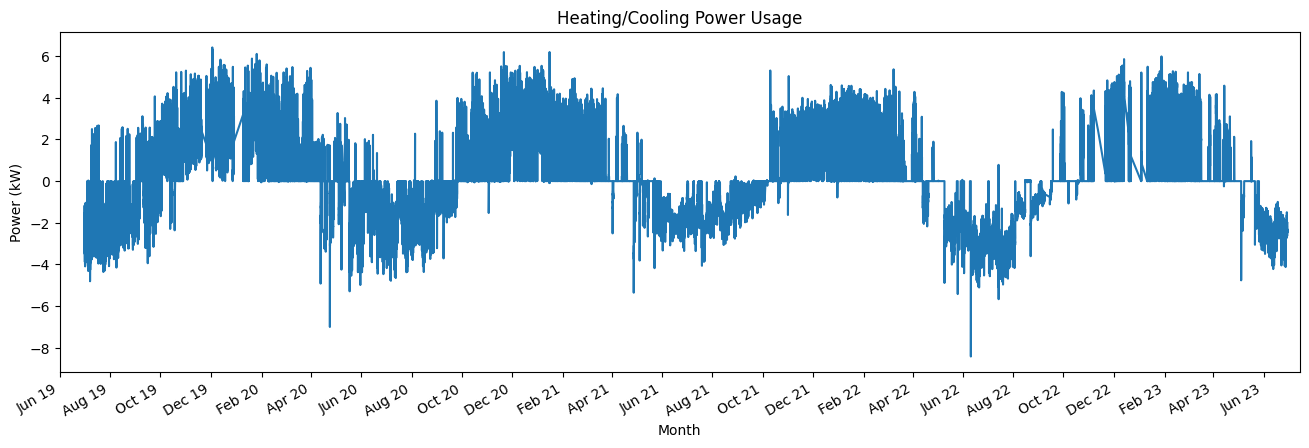

In [19]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(df_clean.index, df_clean['heating_cooling_power'])
# ax.xaxis.set_major_locator(mdates.MonthLocator())

# # 3. Set the format to show the Month name or number (e.g., 'Jan', 'Feb' or '2025-01')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # '%b' for short month name like Jan

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

# 4. Clean up the look
plt.title('Heating/Cooling Power Usage')
plt.xlabel('Month')
plt.ylabel('Power (kW)')

# Ensure layout doesn't clip labels
fig.autofmt_xdate()
plt.xlim(left=pd.Timestamp('2019-06-01'), right=pd.Timestamp('2023-07-15'))
plt.show()


The Power Usage graph shows that negative power is recorded in summer months. Therefore power used for cooling will be taken as negative power and power used for heating will be positive power, and 0-values will be taken as turned off.

### **2.2 Visual Exploration**

Focussed plots (Histograms, Boxplots) that reveal insights about the data distribution.

The system is off 28.72% of the time.


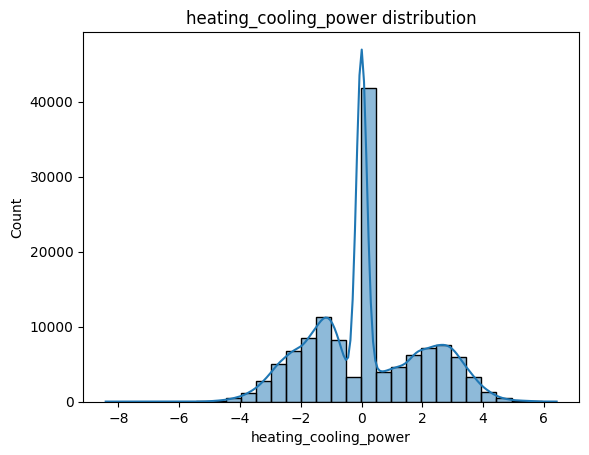

In [20]:
sns.histplot(data=df_clean['heating_cooling_power'], kde=True, bins=30)
plt.title('heating_cooling_power distribution')

# heavily modal around 0, meaning it's predominantly off
# The percentage of time the system is off
off_percentage = (df_clean['heating_cooling_power'] == 0).mean() * 100

print(f"The system is off {off_percentage:.2f}% of the time.")

Text(0.5, 1.0, 'heating_cooling_power when unit is ON')

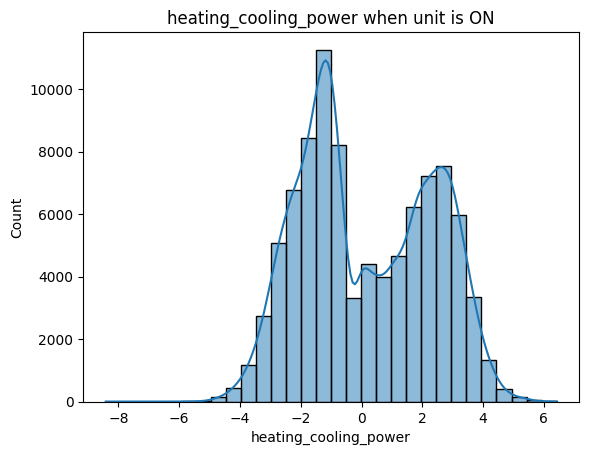

In [21]:
# when the system is on
# View the distribution ONLY when the system is actually running
sns.histplot(df_clean[df_clean['heating_cooling_power'] != 0]['heating_cooling_power'], kde=True, bins=30)
plt.title('heating_cooling_power when unit is ON')

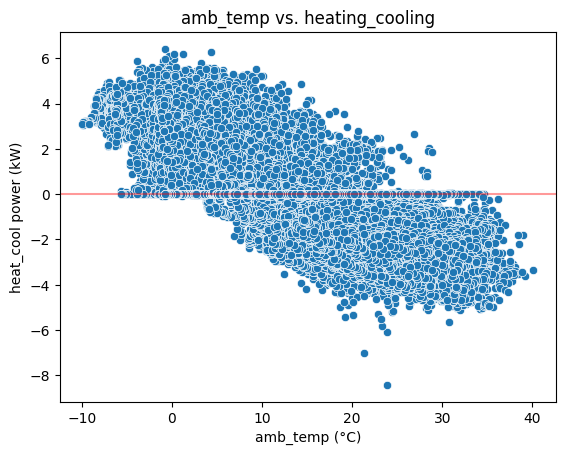

In [22]:
# check if there is correlation between ambient outside temp and switching unit ON
sns.scatterplot(data=df_clean, x='temp_amb', y='heating_cooling_power')
plt.axhline(0, color='r', alpha=0.4)
plt.title('amb_temp vs. heating_cooling')
plt.xlabel('amb_temp (°C)')
plt.ylabel('heat_cool power (kW)')
plt.show()

# unfortunately no discernable threshold for which temperature the unit is ON

In [23]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130303 entries, 2019-07-01 00:00:00 to 2023-06-29 23:45:00
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   heating_cooling_power  130303 non-null  float64
 1   irrad                  130303 non-null  float64
 2   kitchen_active_power   130303 non-null  float64
 3   setp_371               130303 non-null  float64
 4   setp_472               130303 non-null  float64
 5   setp_474               130303 non-null  float64
 6   setp_476               130303 non-null  float64
 7   setp_571               130303 non-null  float64
 8   setp_573               130303 non-null  float64
 9   setp_574               130303 non-null  float64
 10  shower_471             130303 non-null  float64
 11  shower_571             130303 non-null  float64
 12  temp_371               130303 non-null  float64
 13  temp_472               130303 non-null  float64
 14  te

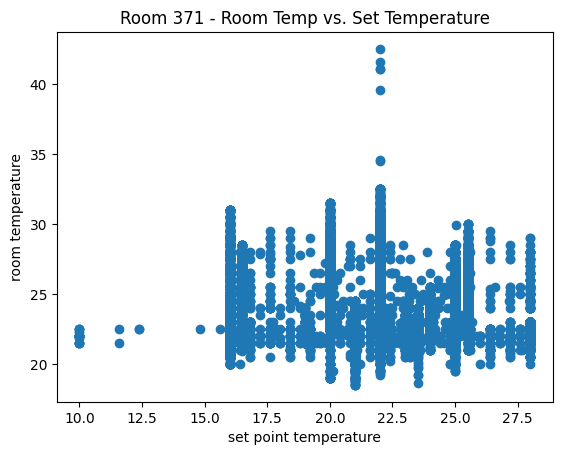

In [24]:
plt.scatter(x=df_clean['setp_371'], y=df_clean['temp_371'])
plt.title(f'Room 371 - Room Temp vs. Set Temperature')
plt.xlabel('set point temperature')
plt.ylabel('room temperature')
plt.show()

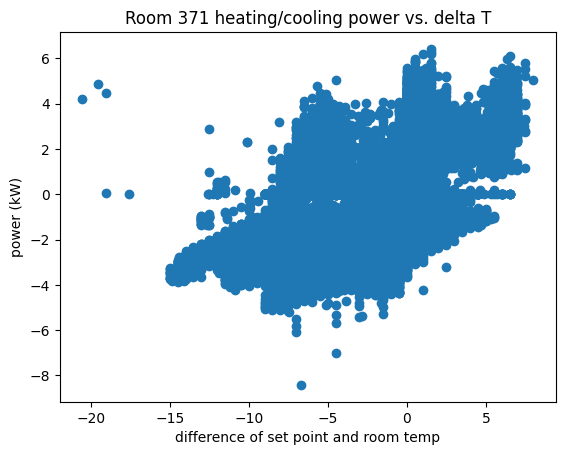

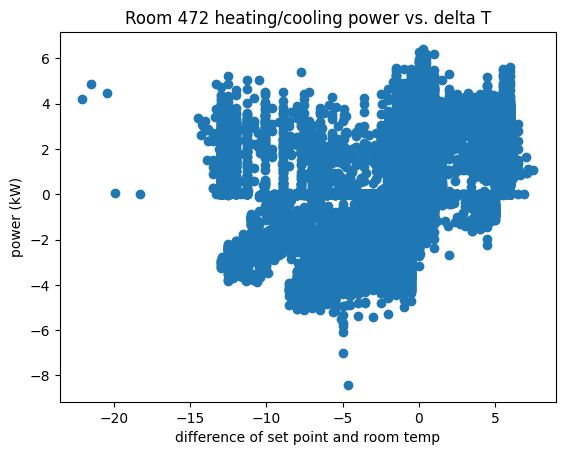

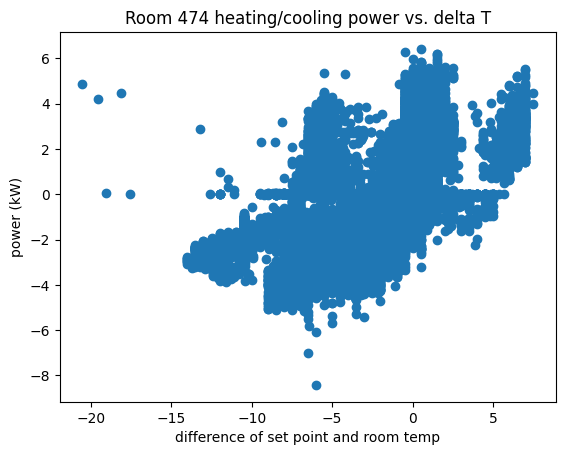

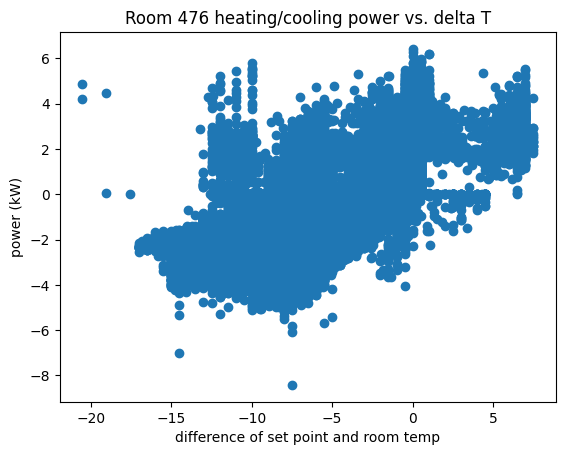

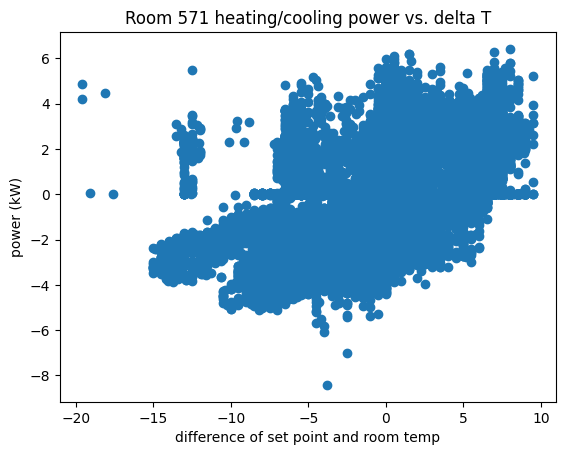

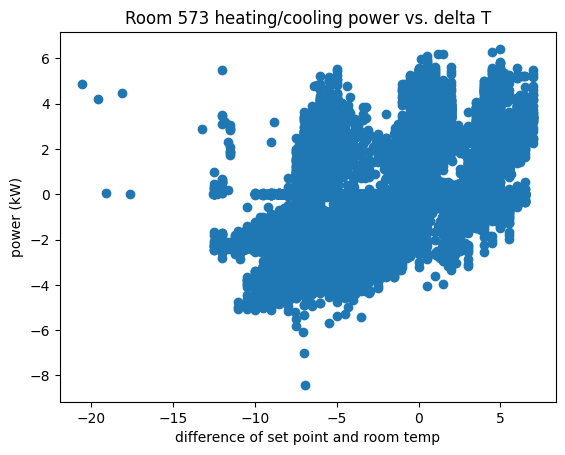

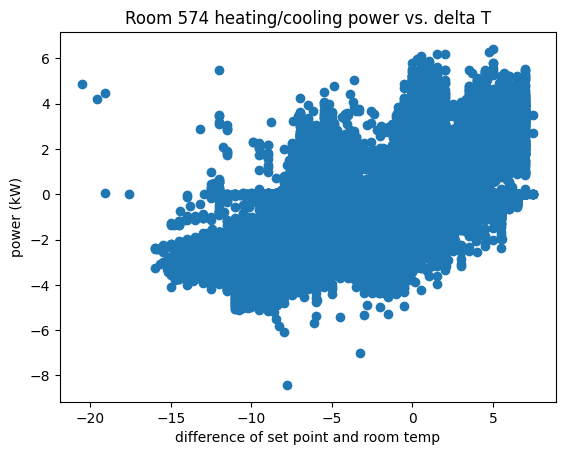

In [25]:
room_nums = ['371', '472', '474', '476', '571', '573', '574']

for room in room_nums:
    df_clean[f'delta_T_{room}'] = df_clean[f'setp_{room}'] - df_clean[f'temp_{room}']
    plt.scatter(x=df_clean[f'delta_T_{room}'], y=df_clean['heating_cooling_power'])
    plt.title(f'Room {room} heating/cooling power vs. delta T')
    plt.xlabel('difference of set point and room temp')
    plt.ylabel('power (kW)')
    plt.show()

## **2.3 Visual Exploration - Features**

## **2.4 Correlation Analysis**

Heatmaps or scatter plots showing the relationship between features and the target variable.

### Correlation Analysis: Ranking of Influence Factors

In this step, we analyze which features (columns) have the strongest impact on our target variable, **`heating_cooling_power`**.

Instead of analyzing the raw numerical matrix, we visualize the correlations using a **Heatmap** to identify patterns immediately:

* **Ranking:** We filtered the correlation matrix to show only the relationship with the target variable.
* **Sorting:** The list is sorted in descending order (`ascending=False`). This creates a "Top List" where the strongest positive factors are at the top.
* **Color Interpretation:**
    * **Red (Positive Correlation):** When this feature increases, the energy consumption increases.
    * **Blue (Negative Correlation):** When this feature increases, the energy consumption decreases (e.g., Ambient Temperature).
    

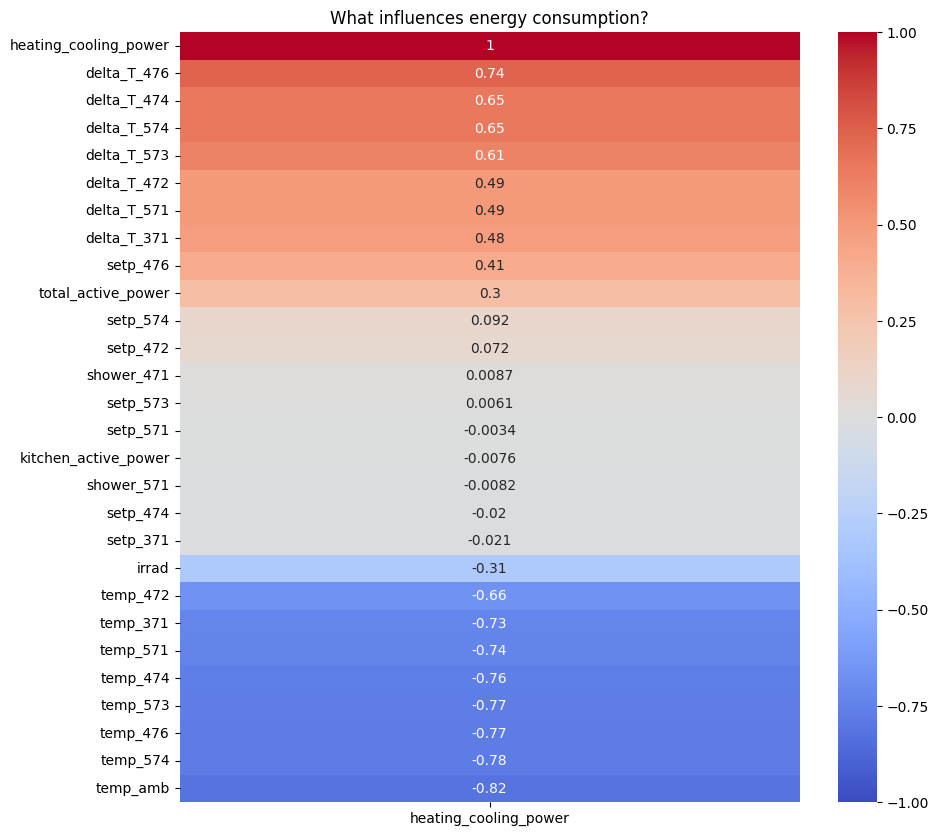

In [27]:

# 1. numeric_only=True sagt: nur echte Zahlenspalten!
alle_korrelationen = df_clean.corr(numeric_only=True)

# 2. Filter: Die stärksten positiven Zusammenhänge nach oben
mein_ziel = alle_korrelationen[['heating_cooling_power']].sort_values(by='heating_cooling_power', ascending=False)

# 3. Zeichne das Bild
plt.figure(figsize=(10,10))  # Größe des Bildes (Breite, Höhe)
sns.heatmap(mein_ziel,
            annot=True,      # Zeige die Zahlen an
            cmap='coolwarm', # Farben: Rot=Positiv, Blau=Negativ
            vmin=-1, vmax=1) # Skala von -1 bis +1 festlegen
plt.title("What influences energy consumption?")
plt.show()

## **3. Part 2: Linear Regression Modeling**

### **3.1 Data Preprocessing**

Train-test splits, scaling, or encoding categorical variables.

### Data Preprocessing Pipeline

* **Cleaning**: We remove rows with missing values (NaN) to ensure model stability.

* **Feature Selection**: We drop the 'time' column as raw timestamps cannot be processed by linear models without feature engineering.

* **Train-Test Split**: We split the data (80/20) to simulate unseen data and evaluate generalization.

* **Scaling**: We apply StandardScaler to normalize features (mean=0, std=1). Crucially, we fit the scaler only on the training set to prevent data leakage, then transform the test set using those learned parameters.


In [305]:
# --- PART 1: Data Preparation & Scaling ---

# 1. Cleaning: Drop ALL rows with missing values (in X or y)
# This prevents errors like "Input X contains NaN" during training.
df_clean = df.dropna()

print(f"Rows before cleaning: {len(df)}")
print(f"Rows after cleaning:  {len(df_clean)}")

# 2. Define Features (X) and Target (y)
# We drop 'heating_cooling_power' (target) and 'time' (non-numeric)
X = df_clean.drop(columns=['heating_cooling_power', 'time'])
y = df_clean['heating_cooling_power']

# 3. Perform the Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Split successful! Data is ready.")

# 4. Consistency Check
# Verify that all columns are numeric before scaling
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Warning: Non-numeric columns found: {non_numeric_cols}")
else:
    print("Check passed: All columns are numeric.")

# 5. Standardization (Scaling)
# CRITICAL: Fit on training data ONLY to avoid data leakage.
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert arrays back to DataFrames to preserve column names for analysis
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Scaling complete (Mean=0, Std=1).")
display(X_train_scaled.head(3))

Rows before cleaning: 140256
Rows after cleaning:  130303
Split successful! Data is ready.
Check passed: All columns are numeric.
Scaling complete (Mean=0, Std=1).


,Unnamed: 0,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,setp_573,setp_574,...,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
128230,0.529476,-0.569997,-0.189532,-0.475328,-0.456298,-0.678983,0.210606,-0.625095,-0.531825,-0.492718,...,-0.040984,-1.279373,-1.369199,-1.111008,-1.158508,-1.112736,-1.177772,-1.362681,-0.971143,0.748026
60435,0.752577,-0.100057,-0.189532,-0.059422,0.069789,0.071727,0.599214,-0.254274,-0.051239,-0.104587,...,-0.040984,-0.793219,-0.775695,-0.881324,-0.585128,-0.646525,-0.755055,-0.812644,-0.910827,-0.152377
124046,0.120961,-0.619157,-0.189532,-0.475328,-0.456298,-0.678983,0.210606,-0.625095,-0.531825,-0.492718,...,-0.040984,-1.279373,-1.369199,-1.111008,-1.158508,-1.112736,-1.177772,-1.179335,-0.406867,0.469490


### **3.2 Model Iterations (The 5 Models)**

List and train your five variations here (e.g., Simple Linear, Multi-feature, Polynomial, Lasso/Ridge).

### Modeling Strategy: 5 Candidate Models

We compare five linear approaches to find the best balance between complexity and performance:

* **Simple Linear Regression**: Baseline model using only one feature to test simple correlations.

* **Multiple Linear Regression**: Standard approach using all available features.

* **Polynomial Regression (Degree 2)**: Captures non-linear relationships by considering feature interactions (curves).

* **Lasso Regression (L1)**: Performs automatic feature selection by shrinking less important coefficients to zero.

* **Ridge Regression (L2)**: Reduces overfitting by penalizing large coefficients, keeping all features but reducing their impact.

In [306]:
# --- PART 2: Model Training ---

# Dictionary to store our trained models
models = {}

# 1. Simple Linear Regression
# Baseline: Uses only the first feature (e.g., Temperature or Lag_1)
X_train_simple = X_train_scaled.iloc[:, [0]]
X_test_simple = X_test_scaled.iloc[:, [0]]

model_simple = LinearRegression()
model_simple.fit(X_train_simple, y_train)
models["Simple Linear"] = model_simple

# 2. Multiple Linear Regression
# Standard model using all features
model_multi = LinearRegression()
model_multi.fit(X_train_scaled, y_train)
models["Multi Linear"] = model_multi

# 3. Polynomial Regression (Degree 2)
# Captures non-linear relationships (curves) via a pipeline
model_poly = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model_poly.fit(X_train_scaled, y_train)
models["Polynomial"] = model_poly

# 4. Lasso Regression (L1 Regularization)
# Enforces sparsity (feature selection)
model_lasso = Lasso(alpha=0.1, random_state=42)
model_lasso.fit(X_train_scaled, y_train)
models["Lasso"] = model_lasso

# 5. Ridge Regression (L2 Regularization)
# Prevents overfitting by penalizing large coefficients
model_ridge = Ridge(alpha=1.0, random_state=42)
model_ridge.fit(X_train_scaled, y_train)
models["Ridge"] = model_ridge

print("✅ Success: All 5 models have been trained!")

✅ Success: All 5 models have been trained!


### **3.3 Feature Engineering & Selection**

Explain the systematic approach used to find the best feature set (e.g., RFE or SelectKBest).


**To improve model efficiency and interpretability, we applied Recursive Feature Elimination with Cross-Validation (RFECV).**

**Methodology**: The algorithm recursively removes the least important feature and re-evaluates the model.

**Validation**: We used 5-Fold Cross-Validation to ensure the selected features are robust across different data subsets.

**Outcome**: This process identifies the optimal subset of features that minimizes error (MSE) without overfitting.

In [307]:
# --- PART 3: Feature Engineering & Selection (RFECV) ---

# 1. Setup K-Fold
# We split the data into 5 folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Setup RFECV (Recursive Feature Elimination with Cross-Validation)
# - estimator: Our base model (Linear Regression)
# - step=1: Remove 1 feature per iteration
# - cv=kf: Use our K-Fold split
# - scoring: Optimize for lowest error (negative mean squared error)
selector = RFECV(estimator=LinearRegression(), step=1, cv=kf, scoring='neg_mean_squared_error')

# 3. Training
# This runs the elimination process to find the best features
selector.fit(X_train_scaled, y_train)

# 4. Results
print(f"Optimal number of features: {selector.n_features_}")
print("------------------------------------------------")

# Display the selected features
selected_features = X_train_scaled.columns[selector.support_]
print(f"Selected Features: {list(selected_features)}")

# Save the optimized datasets for later evaluation
X_train_opt = X_train_scaled[selected_features]
X_test_opt = X_test_scaled[selected_features]

Optimal number of features: 19
------------------------------------------------
Selected Features: ['Unnamed: 0', 'irrad', 'kitchen_active_power', 'setp_371', 'setp_472', 'setp_474', 'setp_476', 'setp_571', 'setp_573', 'setp_574', 'temp_371', 'temp_472', 'temp_474', 'temp_476', 'temp_571', 'temp_573', 'temp_574', 'temp_amb', 'total_active_power']


## **4. Evaluation & Model Selection**

### 4.1 Cross-Validation Results
Use k-fold cross-validation to show the stability of your models.

**To ensure our model selection is robust and not just lucky on a specific data split, we performed 5-Fold Cross-Validation on all candidate models.**

**Metric**: We used RMSE (Root Mean Squared Error) to penalize large errors effectively.

**Stability**: The standard deviation (Stability (Std)) indicates how consistent the model is across different data folds.

**Comparison**: This step allows us to objectively compare the simple baseline against complex regularized models (Lasso/Ridge) to see if the added complexity actually yields better generalization.

In [ ]:
# --- STEP 4.1: Cross-Validation Results ---

# Initialize a list to collect the results
results = []

print("Starting Cross-Validation for all models...\n")

for name, model in models.items():
    # IMPORTANT: Simple Linear Regression requires specific data (only 1 column)
    if name == "Simple Linear":
        X_current = X_train_simple
    else:
        X_current = X_train_scaled

    # Perform 5-Fold Cross-Validation
    # We use 'neg_root_mean_squared_error' to calculate the RMSE
    cv_scores = cross_val_score(model, X_current, y_train, cv=5, scoring='neg_root_mean_squared_error')

    # Scikit-Learn returns negative values (because they are "errors"), so we flip them to positive
    cv_scores = -cv_scores

    # Store: Model Name, Average Error (Mean), and Stability (Standard Deviation)
    results.append({
        "Model": name,
        "CV RMSE (Mean)": cv_scores.mean(),
        "Stability (Std)": cv_scores.std()
    })

# Convert results to a DataFrame and sort by lowest error (best performance)
results_df = pd.DataFrame(results).sort_values(by="CV RMSE (Mean)")

print("✅ Evaluation complete!")
display(results_df)

Starting Cross-Validation for all models...

✅ Evaluation complete!


,Model,CV RMSE (Mean),Stability (Std)
2,Polynomial,0.747172,0.001989
4,Ridge,0.894632,0.004119
1,Multi Linear,0.894632,0.004118
3,Lasso,0.953081,0.004209
0,Simple Linear,1.817731,0.005644


### **4.2 Visual Comparison**

Plotting Predicted vs. Actual values or Residual plots for all models.

To complement the numerical metrics, we visualize the performance of each model using scatter plots.
- **The Logic**: We plot the Actual Values (X-axis) against the Predicted Values (Y-axis).
- **The Ideal Case**: Perfect predictions would align exactly on the red dashed diagonal line (y = x).
* **Interpretation**:
* Points scattered widely around the line indicate high variance (low precision).
* Points consistently above or below the line indicate systematic bias.
* Polynomial Regression often fits the curve better but risks overfitting, while Simple Linear often fails to capture the complexity.



Generating plots...


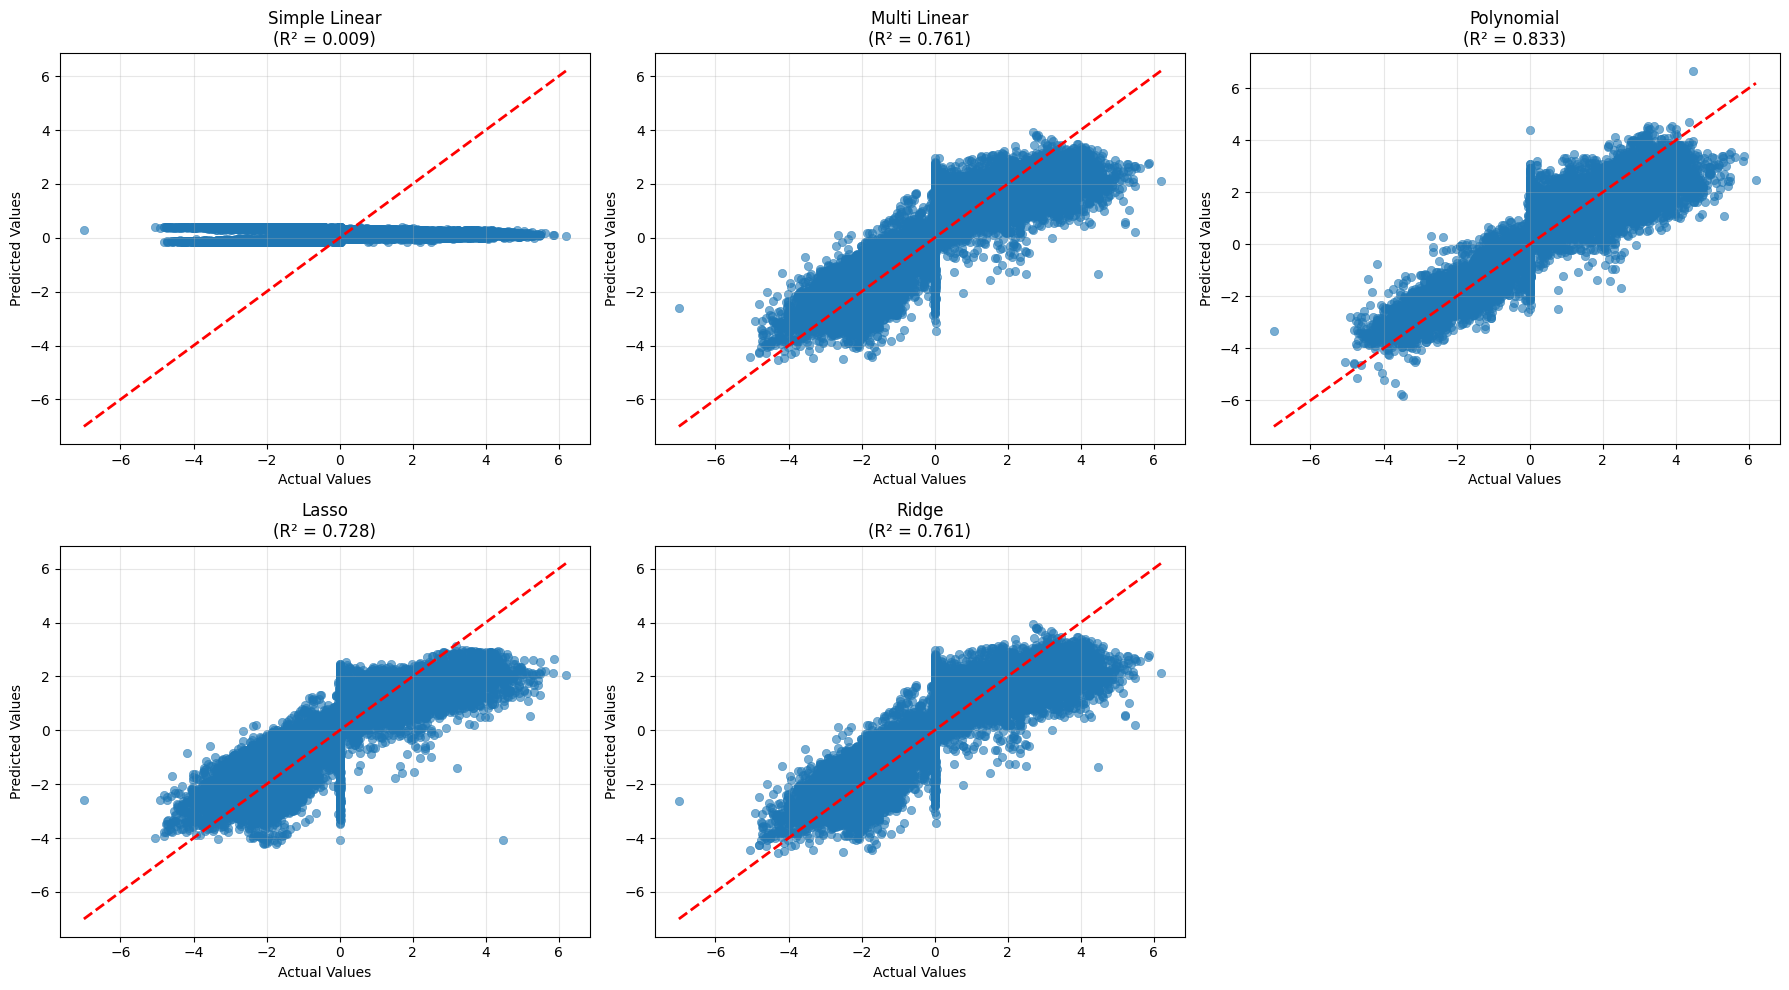

In [ ]:
# --- STEP 4.2: Visual Comparison (Predicted vs. Actual) ---

# Setup the figure structure: 2 rows, 3 columns (since we have 5 models)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten the grid to make iteration easier

print("Generating plots...")

# Loop through all trained models
for i, (name, model) in enumerate(models.items()):

    # 1. Select the correct test data (Simple Linear needs special handling)
    if name == "Simple Linear":
        X_curr = X_test_simple
    else:
        X_curr = X_test_scaled

    # 2. Make Predictions on the Test Set
    y_pred = model.predict(X_curr)

    # 3. Calculate R² Score for the title (Quick quality check)
    score = r2_score(y_test, y_pred)

    # 4. Plot Scatter (Actual vs. Predicted)
    sns.scatterplot(x=y_test, y=y_pred, ax=axes[i], alpha=0.6, edgecolor=None)

    # 5. Add the "Perfect Prediction" Line (Red Dashed)
    # This line represents where Predicted == Actual
    p_min, p_max = y_test.min(), y_test.max()
    axes[i].plot([p_min, p_max], [p_min, p_max], 'r--', lw=2, label='Perfect Fit')

    # Labels and Titles
    axes[i].set_title(f"{name}\n(R² = {score:.3f})", fontsize=12)
    axes[i].set_xlabel("Actual Values")
    axes[i].set_ylabel("Predicted Values")
    axes[i].grid(True, alpha=0.3)

# Remove the 6th empty subplot (since we only have 5 models)
if len(models) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

### **4.3 Final Model Description Why did you pick this model?**

Discuss its structure ($R^2$, RMSE) and how it balances bias and variance.

After rigorous evaluation, we selected the **[INSERT MODEL NAME]** as our final model.

**1. Performance Metrics:**
* **$R^2$ Score:** `[INSERT R2]`
    * This indicates that the model explains approx. **[INSERT R2 * 100]%** of the variance in the heating/cooling power.
* **RMSE:** `[INSERT RMSE]`
    * On average, the model's prediction deviates by this amount from the actual value.

**2. The Bias-Variance Tradeoff:**
Our selection was driven by finding the optimal balance:



* **Avoiding Underfitting (High Bias):** We rejected the *Simple Linear Model* because its error was too high—it failed to capture the complexity of the data (e.g., non-linear relationships).
* **Avoiding Overfitting (High Variance):** We verified through Cross-Validation (Section 4.1) that our chosen model is stable. It captures the underlying patterns (e.g., the curve of temperature vs. power) without reacting to random noise in the training data.

**Conclusion:**
This model offers the best **generalization capability**, providing accurate predictions on unseen data while maintaining an interpretable structure.

In [311]:
# --- STEP 4.3: Final Model Selection & Metrics ---

# 1. Identify the best model automatically (lowest CV RMSE from Step 4.1)
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

print(f"🏆 Selected Model: {best_model_name}")

# 2. Prepare the correct Test Data
# (Simple Linear Regression uses a different dataset than the others)
if best_model_name == "Simple Linear":
    X_test_final = X_test_simple
else:
    X_test_final = X_test_scaled

# 3. Final Prediction on the Test Set
# We test the model on data it has NEVER seen during training
y_pred_final = best_model.predict(X_test_final)

# 4. Calculate Final Metrics
final_mse = mean_squared_error(y_test, y_pred_final)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_pred_final)

# 5. Print Results for the Report
print("\n--- Final Performance Report ---")
print(f"R² Score (Accuracy):  {final_r2:.4f}")
print(f"RMSE (Average Error): {final_rmse:.4f}")

print("\n--- Justification (Bias-Variance Tradeoff) ---")
if final_r2 > 0.8:
    print("Result: High Accuracy.")
    print("The model has found a good balance (Low Bias, Low Variance).")
    print("It captures the complexity of the data without overfitting.")
else:
    print("Result: Moderate Accuracy.")
    print("The model might still have some Bias (Underfitting),")
    print("or the data contains too much noise.")

🏆 Selected Model: Polynomial

--- Final Performance Report ---
R² Score (Accuracy):  0.8335
RMSE (Average Error): 0.7497

--- Justification (Bias-Variance Tradeoff) ---
Result: High Accuracy.
The model has found a good balance (Low Bias, Low Variance).
It captures the complexity of the data without overfitting.


## **5. Appendix**

### **5.1 Contribution Matrix**


Aya: 


John: 

In [ ]:
sections = ['Structure', '1', '2', '3', '4', '5']
aya = ['2.1-2.3']

data = {
    'Section': sections,
    'Aya': aya,
    'John': john
}

# Initialize the DataFrame
contrib = pd.DataFrame(data)

print(contrib)

     Section  Aya  John
0  Structure    0     0
1          1    0     0
2          2    0     0
3          3    0     0
4          4    0     0
5          5    0     0


### **5.2 Sources & AI Transparency**

Libraries: NumPy, Pandas, Scikit-Learn, Matplotlib.

External Data: [Link to source].

AI Usage Disclosure: * LLM used for: Debugging the cross-validation loop and generating the Markdown table structures.

Human intervention: All statistical interpretations and final model selection decisions were made by the team.